In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

from scipy import stats
from imblearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

In [8]:
train = pd.read_csv('../data/train_mod.csv')
test = pd.read_csv('../data/test_mod.csv')

test_id = test['id']

In [9]:
X = train.drop(['loan_status', 'id'], axis=1)
y = train['loan_status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

vars_cat = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
vars_num = X_train.select_dtypes(include=['float64', 'int64']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, vars_num),
    ('cat', categorical_transformer, vars_cat),
])

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

In [10]:
folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

param_dist = {'learning_rate': stats.uniform(0.01, 0.99),
              'max_depth': stats.randint(2, 12),
              'subsample': stats.uniform(0.1, 1),
              'colsample_bytree': stats.uniform(0.1, 1),
              'n_estimators': stats.randint(50, 1000),
              'reg_lambda': stats.uniform(0.0001, 1),
              'reg_alpha': stats.uniform(0.0001, 1)
              }

classifier = LGBMClassifier(use_label_encoder=False,random_state=42)
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
lgbm = RandomizedSearchCV(classifier,param_dist,cv=cv, verbose=1,scoring='roc_auc',n_iter=10,random_state=42)

lgbm.fit(X_train,y_train)
print(f'AUC CV: {round(lgbm.best_score_,2)}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Info] Number of positive: 4650, number of negative: 28186
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 32836, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.141613 -> initscore=-1.801958
[LightGBM] [Info] Start training from score -1.801958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

In [11]:
lgbm = LGBMClassifier(
    **lgbm.best_params_, 
    random_state=42
)

# Train the model on the training set
lgbm.fit(X_train, y_train)

# Predictions (classes) and probabilities on the test set
y_pred = lgbm.predict(X_val)  
y_pred_prob = lgbm.predict_proba(X_val)[:, 1]  

# Model evaluation
auc_score = roc_auc_score(y_val, y_pred_prob)
print(f"AUC-ROC Score: {auc_score:.4f}")

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

[LightGBM] [Info] Number of positive: 5812, number of negative: 35233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1907
[LightGBM] [Info] Number of data points in the train set: 41045, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.141601 -> initscore=-1.802058
[LightGBM] [Info] Start training from score -1.802058
AUC-ROC Score: 0.9579
Accuracy Score: 0.9535

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     15055
           1       0.94      0.73      0.82      2537

    accuracy                           0.95     17592
   macro avg       0.95      0.86      0.90     17592
weighted avg       0.95      0.95      0.95     17592



In [12]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1_score = f1_score(y_val, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

Accuracy: 0.9535015916325602
Precision: 0.9528562876371713
Recall: 0.9535015916325602
F1 Score: 0.9510216333173267


In [13]:
test

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,income_loan_ratio,age_category,emp_length_group,int_rate_group,age_income_ratio,age_emp_ratio,age_loan_ratio
0,58645,23,69000,RENT,3.000000,HOMEIMPROVEMENT,F,25000,15.76,0.36,0,2,2.760000,young-adult,junior,10-20,0.000333,7.666667,0.000920
1,58646,26,96000,MORTGAGE,6.000000,PERSONAL,C,10000,12.68,0.10,1,4,9.600000,young-adult,semi-senior,10-20,0.000271,4.333333,0.002600
2,58647,26,30000,RENT,5.000000,VENTURE,E,4000,17.19,0.13,1,2,7.500000,young-adult,junior,10-20,0.000867,5.200000,0.006500
3,58648,33,50000,RENT,4.000000,DEBTCONSOLIDATION,A,7000,8.90,0.14,0,7,7.142857,adult,junior,0-10,0.000660,8.250000,0.004714
4,58649,26,102000,MORTGAGE,8.000000,HOMEIMPROVEMENT,D,15000,16.32,0.15,1,4,6.800000,young-adult,semi-senior,10-20,0.000255,3.250000,0.001733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39093,97738,22,31200,MORTGAGE,2.000000,DEBTCONSOLIDATION,B,3000,10.37,0.10,0,4,10.400000,young-adult,junior,10-20,0.000705,11.000000,0.007333
39094,97739,22,48000,MORTGAGE,6.000000,EDUCATION,A,7000,6.03,0.15,0,3,6.857143,young-adult,semi-senior,0-10,0.000458,3.666667,0.003143
39095,97740,51,60000,MORTGAGE,4.687068,PERSONAL,A,15000,7.51,0.25,0,25,4.000000,adult,junior,0-10,0.000850,10.881002,0.003400
39096,97741,22,36000,MORTGAGE,4.000000,PERSONAL,D,14000,15.62,0.39,1,4,2.571429,young-adult,junior,10-20,0.000611,5.500000,0.001571


In [14]:
test = preprocessor.transform(test)

y_pred_prob = lgbm.predict_proba(test)[:,1]
predictions = pd.DataFrame(y_pred_prob)


predictions = predictions.reset_index().rename(columns={
    'index':'id',
    0:'loan_status'
})

predictions['id'] = test_id

In [15]:
y_pred_prob

array([0.9691773 , 0.02343412, 0.6668484 , ..., 0.01380223, 0.36260541,
       0.93713395])

In [ ]:
predictions.to_csv("light_gbm_proba_features.csv", index=False)

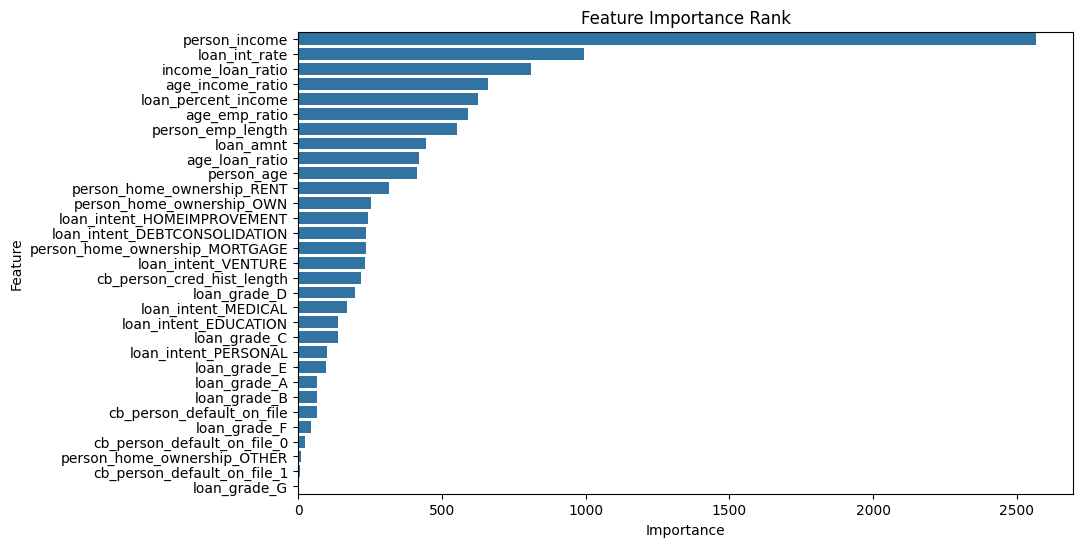

In [ ]:
num_features = vars_num

# Recuperar nombres de las columnas categóricas (OneHotEncoded)
cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(vars_cat)

# Combinar todos los nombres de columnas procesadas
all_features = list(num_features) + list(cat_features)

X_train_df = pd.DataFrame(X_train, columns=all_features)
X_val_df = pd.DataFrame(X_val, columns=all_features)

feature_importances = lgbm.feature_importances_

# Crear un DataFrame con las importancias
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
})

# Ordenar por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

Text(0.5, 1.0, 'Feature Importance Rank')

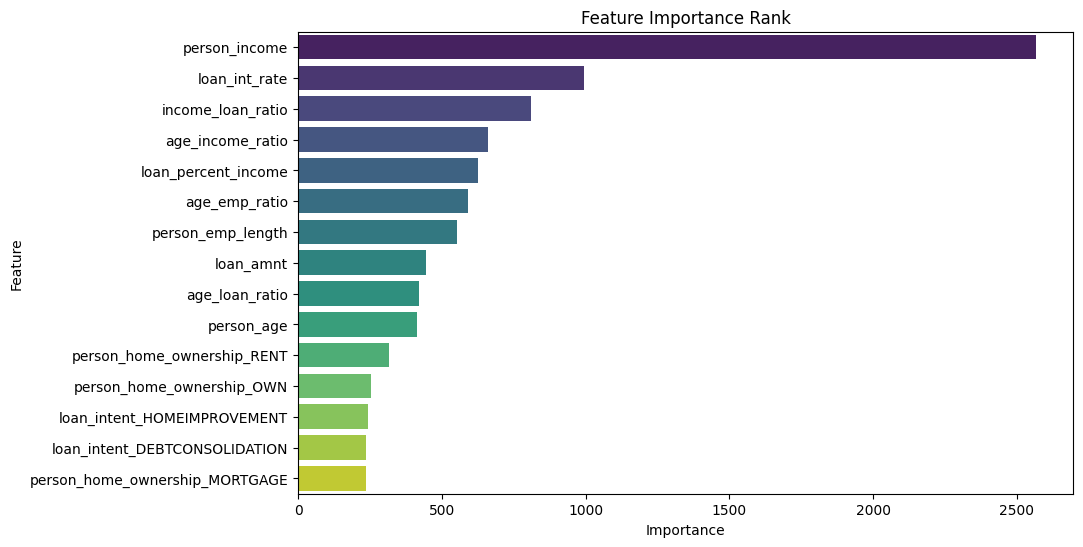

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Feature Importance Rank')
